In [1]:
import gzip
import io
import pandas as pd
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import math

In [58]:
# Settings
in_filepath = 'data/GRCh38.UCSC.SimpleRepeats.tsv.gz'
out_filepath = 'GRCh38.UCSC.SimpleRepeats.merged.trgt.bed'

max_cluster_len = 5000 # Exclude clusters of loci > than this many bp
join_dist = 200 # If loci are within this many bp, join them into a compound locus (no interruption kept currently)

In [3]:
def is_gzip(file_path):
    with open(file_path, 'rb') as file:
        return file.read(2) == b'\x1f\x8b'

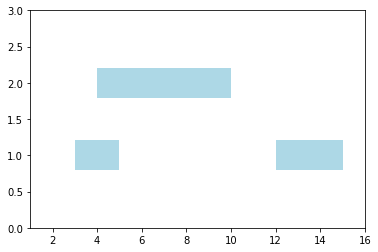

In [4]:
def plot_intervals(bed):
    """Assumes sorted intervals - need to test this?
    
    bed is a pandas datafram with at least the columns chrom, start and end
    """
    assert len(set(bed['chrom']))==1 # check all chromosomes are the same
    
    intervals = list(zip(bed['start'], bed['end']))
    layers = [[intervals[0]]]
    minstart, maxend = intervals[0]
    
    for interval in intervals[1:]:
        
        if interval[0] < minstart: minstart = interval[0]
        if interval[1] > maxend: maxend = interval[1]
        for layer in layers:
            if layer[-1][-1] < interval[0]:
                layer.append(interval)
                break
        else:
            layers.append([interval])

    plt.figure()
    for i, lay in enumerate(layers):
        x1, x2 = zip(*lay)
        plt.hlines([i + 1] * len(x1), x1, x2, lw=30, color='lightblue')
# To add text. This isn't working yet...
#         print(x1, x2)
#         for bar in zip(x1, x2):
#             print(bar)
#             if text is not None:
#                 plt.text(np.mean(bar), i + 1, 'test', fontsize=12,
#                          horizontalalignment='center', verticalalignment='center', )

    plt.xlim(minstart - 2, maxend + 1)
    plt.ylim(0, len(layers) + 1)

df1 = pd.DataFrame([
    ['chr1', 3, 5],
    ['chr1', 4, 10],
    ['chr1', 12, 15],
    ],
    columns=['chrom', 'start', 'end']
)

plot_intervals(df1)


In [5]:
if is_gzip(in_filepath):
    bed_file = io.TextIOWrapper(gzip.open(in_filepath, 'rb'), encoding='utf-8')
else:
    bed_file = open(in_filepath)
        
bed = pd.read_table(bed_file)
bed.drop(columns='#bin', inplace=True)
bed.rename(columns = {'chromStart':'start', 'chromEnd': 'end'}, inplace=True)
# print(bed)
assert bf.core.checks.is_bedframe(bed)

print('Rows in bed: ', len(bed))

Rows in bed:  1049715


In [6]:
def fix_overlaps(clusterbed, pct_overlap = 5):
    
    if len(clusterbed) == 1:
        return(clusterbed)
    
    # If multiple, take the largest
    maxlen = (clusterbed['end'] - clusterbed['start']).max()
    best = clusterbed[clusterbed['end'] - clusterbed['start'] == maxlen]
    
    # If tied, take the highest score
    if len(best) > 1:
        maxscore = (best['score']).max()
        best = best[best['score'] == maxscore]
        
    # If still tied, take the smallest period
    if len(best) > 1:
        minperiod = (best['period']).min()
        best = best[best['period'] == minperiod]
        
    # If still tied, take the first
    if len(best) > 1:
        best = best.head(1)
    
    assert len(best) == 1
    
    # Check if any intervals remain that don't overlap the largest, or only overlap by less than x%
    # Not sure if this is needed at all?
#     overlaps = bf.coverage(clusterbed, best)
#     overlaps['pct_overlap'] = overlaps['coverage']/(clusterbed['end'] - clusterbed['start'])*100
#     alsokeep = overlaps[overlaps['pct_overlap'] < pct_overlap]
    
    # Trim overlapping sequence
    trimmed = bf.subtract(clusterbed, best)

    if len(trimmed) > 0:
        return bf.sort_bedframe(pd.concat([best, trimmed], join='inner', ignore_index=True, copy=True))
    else:
        return best.copy()


# Tests

# HD locus example
# df1 = pd.DataFrame([
#     ['chr4', 3074877, 3074940, 3, 119],
#     ['chr4', 3074877, 3074940, 3, 200],
#     ['chr4', 3074877, 3074940, 2, 200],
#     ['chr4', 3074939, 3074968, 3, 51],
#     ['chr4', 3074970, 3074977, 3, 51],
#     ],
#     columns=['chrom', 'start', 'end', 'period', 'score']
# )

# Failed first attempt (good test case)
# df1 = pd.DataFrame([
#     ['chr1', 12582784, 12583841, 3, 119],
#     ['chr1', 12583317, 12583892, 3, 119],
#     ],
#     columns=['chrom', 'start', 'end', 'period', 'score']
# )

# One interval inside other
# df1 = pd.DataFrame([
#     ['chr1', 154140082, 154141019, 3, 119],
#     ['chr1', 154140668, 154140702, 3, 119],
#     ],
#     columns=['chrom', 'start', 'end', 'period', 'score']
# )
# plot_intervals(df1)
# print(fix_overlaps(df1))
# plot_intervals(fix_overlaps(df1))



In [7]:
bedclusters = bf.cluster(bed, min_dist=None)
print('Number of clusters:', len(bedclusters['cluster'].unique()))
bedclusters.head()


Number of clusters: 704534


,chrom,start,end,name,period,copyNum,consensusSize,perMatch,perIndel,score,A,C,G,T,entropy,sequence,cluster,cluster_start,cluster_end
0,chr1,12582784,12583841,trf,57,18.3,57,66,20,241,22,51,1,24,1.56,TCCATCCATCCATCCATCCATCCATCCATCCATCCCTCCCTCATCT...,3774,12582784,12583892
1,chr1,12582839,12582993,trf,4,37.8,4,75,13,93,21,52,0,25,1.51,TCCA,3774,12582784,12583892
2,chr1,12582910,12583333,trf,30,13.5,30,69,18,218,23,51,1,23,1.57,CATCCATCCATCCACTCACCTACCCCACTC,3774,12582784,12583892
3,chr1,22020082,22020671,trf,308,1.9,307,83,4,774,31,22,27,18,1.97,CTGTAATCCCAGCACTTTGGGAGGCCGAGGCAAGAGGATCACCTGA...,6261,22020082,22020671
4,chr1,121609878,121734316,trf,342,365.9,341,72,8,44205,29,22,19,28,1.98,AAATATCCACTTGCAGATTCTACAAAAAGAGTGTTTCAAAACTGCT...,27737,121609789,121734418


In [8]:
%%time

n_big = 0

# Fix overlapping intervals by choosing the largest then trimming the others
all_list = []
for cluster in bedclusters['cluster'].unique():
    clusterbed = bedclusters.loc[bedclusters['cluster'] == cluster]
    
    if clusterbed.iloc[0]['cluster_end'] - clusterbed.iloc[0]['cluster_start'] > max_cluster_len:
        n_big += 1
        continue

    if len(clusterbed) == 1:
        all_list.append(clusterbed)
        
    if len(clusterbed) > 1:
        non_overlapping = fix_overlaps(clusterbed)
        all_list.append(non_overlapping)
    
all_non_overlappping = pd.concat(all_list, ignore_index=True, copy=True)
    
print('skipped due to size: ', n_big)
all_non_overlappping

skipped due to size:  1022
CPU times: user 1h 19min 59s, sys: 2min 55s, total: 1h 22min 54s
Wall time: 1h 15min


,chrom,start,end,name,period,copyNum,consensusSize,perMatch,perIndel,score,A,C,G,T,entropy,sequence,cluster,cluster_start,cluster_end
0,chr1,12582784,12583841,trf,57.0,18.3,57.0,66.0,20.0,241.0,22.0,51.0,1.0,24.0,1.56,TCCATCCATCCATCCATCCATCCATCCATCCATCCCTCCCTCATCT...,3774.0,12582784.0,12583892.0
1,chr1,12583841,12583892,trf,4.0,137.2,4.0,74.0,12.0,308.0,23.0,50.0,1.0,24.0,1.56,TCCA,3774.0,12582784.0,12583892.0
2,chr1,22020082,22020671,trf,308.0,1.9,307.0,83.0,4.0,774.0,31.0,22.0,27.0,18.0,1.97,CTGTAATCCCAGCACTTTGGGAGGCCGAGGCAAGAGGATCACCTGA...,6261.0,22020082.0,22020671.0
3,chr1,154140082,154141019,trf,316.0,2.9,314.0,84.0,5.0,1121.0,33.0,22.0,27.0,16.0,1.95,GCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCAAGGCGGGCAGA...,30544.0,154140082.0,154141019.0
4,chr1,155188507,155188675,trf,60.0,2.8,60.0,90.0,0.0,255.0,10.0,24.0,52.0,12.0,1.69,GGCCGAGGTGACACCGTGGGCTGGGGGGGCGGTGGAGCCCGGGGCC...,30812.0,155188507.0,155192051.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834289,chr22_KI270738v1_random,25021,25115,trf,5.0,18.8,5.0,81.0,4.0,109.0,42.0,2.0,34.0,21.0,1.65,GAATG,390298.0,25021.0,25115.0
834290,chr22_KI270738v1_random,96277,96302,trf,16.0,2.2,16.0,100.0,0.0,72.0,44.0,11.0,0.0,44.0,1.39,AAAATTTTTTTCTACA,390301.0,96277.0,99373.0
834291,chr22_KI270738v1_random,96302,99373,trf,171.0,18.0,169.0,78.0,6.0,2924.0,31.0,19.0,17.0,30.0,1.95,TTCTACAAAAAGAGTGTTTCAAACTGCTCTATCAAAAGAAATGTTC...,390301.0,96277.0,99373.0
834292,chr22_KI270739v1_random,31113,35940,trf,171.0,28.3,171.0,78.0,3.0,4591.0,32.0,21.0,15.0,30.0,1.94,CAGATTCTACAAAAAGAGTGTTTCAAACCTGCTCTATGAAATGGAA...,390303.0,31113.0,35940.0


In [10]:
# Cluster loci within x bp of each other

# Drop old cluster columns
all_non_overlappping.drop(columns=['cluster', 'cluster_start', 'cluster_end'], inplace = True)
bedclusters2 = bf.cluster(bed, min_dist=join_dist)

chr4	3074877	3074990	ID=chr4_3074877_3074990;MOTIFS=CAG,GCC,AT;STRUC=(CAG)n(GCC)n(AT)n


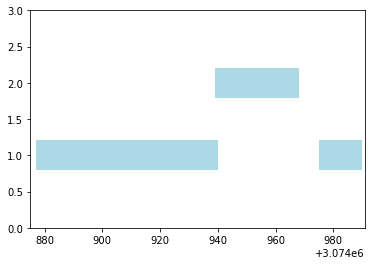

In [54]:
def merge_loci(clusterbed):
    """Join simple repeats into compound loci
    Non-repetitive sequence between them will be ignored.
    
    Output format example string: 
    chr1	57367043	57367119	ID=chr1_57367043_57367119;MOTIFS=AAAAT,GAAAT;STRUC=(AAAAT)n(GAAAT)n(AAAAT)n
    """

    assert len(set(clusterbed['chrom']))==1 # check all chromosomes are the same
    # Check that none overlap?
    # Check sorted?
    
    motifs = clusterbed['sequence']
    
    uniq_motifs = ','.join(list(dict.fromkeys(motifs))) # Requires Python 3.7+ to maintain ordering
    struc = ''.join([f'({x})n'.format() for x in motifs])

    chrom = clusterbed['chrom'].values[0]
    start = clusterbed['cluster_start'].values[0]
    end = clusterbed['cluster_end'].values[0]

    loc_id = f'{chrom}_{start}_{end}'.format()
    outline = f'{chrom}\t{start}\t{end}\tID={loc_id};MOTIFS={uniq_motifs};STRUC={struc}'.format()
    return outline
    
# Tests

# HD locus example (ish)
df1 = pd.DataFrame([
    ['chr4', 3074877, 3074940, 'CAG', 3074877, 3074990],
    ['chr4', 3074939, 3074968, 'GCC', 3074877, 3074990],
    ['chr4', 3074975, 3074990, 'AT', 3074877, 3074990],
    ],
    columns=['chrom', 'start', 'end', 'sequence', 'cluster_start', 'cluster_end']
)

plot_intervals(df1)
print(merge_loci(df1))

In [ ]:
# Join nearby loci into compound ones
n_big = 0
merged = 0
max_merge = 0
biggest_cluster = None

with open(out_filepath, 'w') as outfile:
    for cluster in bedclusters2['cluster'].unique():
        clusterbed = bedclusters2.loc[bedclusters2['cluster'] == cluster]

        if clusterbed['cluster_end'].values[0] - clusterbed['cluster_start'].values[0] > max_cluster_len:
            n_big += 1
            continue
        
        if len(clusterbed) > 1:
            merged += 1
            if len(clusterbed) > max_merge:
                max_merge = len(clusterbed)
                biggest_cluster = clusterbed

        outfile.write(merge_loci(clusterbed) + '\n')
            #all_merged = pd.concat([all_merged, merged_loci], ignore_index=True, copy=True)
    
print('skipped due to size: ', n_big)
print('This many loci are compound: ', merged)
biggest_cluster
#all_merged

In [ ]:
# If any cluster overlap a known pathogenic locus, replace them with the manually curated pathogenic locus